In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


# 텐서플로 2.0의 가장 중요한 변화

- 먼저 더 이상 "케라스를 써야 하나요? 텐서플로를 써야 하나요?"라는 질문은 의미 없다. 케라서는 이제 텐서플로의 일부이기 때문이다.

- 또 다른 질무은 "케라스를 서야 합니까? tf.keras를 써야 합니까?"인데, tf.keras는 텐서플로 내부에 케라스를 구현해 놓은 것이다. 따라서 즉시(eager) 실행, tf.data와 다른 이점 등 다른 텐서플로 API와의 좀 더 나은 통합을 원한다면 케라스 대신 tf.keras를 써야함.

## tensorflow 1.0과 2.0의 비교

In [10]:
#tensorflow 1.X 를 사용한 코드

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

in_a = tf.placeholder(dtype=tf.float32, shape=(2))
in_b = tf.placeholder(dtype=tf.float32, shape=(2))

def forward(x):
  with tf.variable_scope("matmul", reuse=tf.AUTO_REUSE):
    W = tf.get_variable("W", initializer=tf.ones(shape=(2,2)))
    b = tf.get_variable("b", initializer=tf.zeros(shape=(2)))
    return W * x + b

out_a = forward(in_a)
out_b = forward(in_b)

reg_loss = tf.losses.get_regularization_loss(scope="matmul")

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  outs = sess.run([out_a, out_b, reg_loss],
                feed_dict={in_a: [1, 0], in_b: [0, 1]})
    

### 변환 후 

- 변수는 파이썬 지역 객체
- forward 함수는 여전히 필요한 계산을 정의
- Session.run 호출은 forward 함수를 호출하는 것으로 변경
- tf.fucntion 데코레이터는 선택 사항으로 성능을 위해 추가 가능
- 어떤 전역 컬렉션도 참조하지 않고 규제를 직접 계산
- **세션이나 플레이스홀터를 사용하지 않음**

In [12]:
# tensorflow 2.0 을 사용한 코드

import tensorflow as tf

W = tf.Variable(tf.ones(shape=(2,2)), name="W")
b = tf.Variable(tf.zeros(shape=(2)), name="b")

@tf.function
def forward(x):
  return W * x + b

out_a = forward([1,0])
print(out_a)

Tensor("StatefulPartitionedCall:0", shape=(2, 2), dtype=float32)


In [14]:
out_b = forward([0,1])
print(out_b)
regularizer = tf.keras.regularizers.l2(0.04)
reg_loss = regularizer(W)

Tensor("StatefulPartitionedCall_2:0", shape=(2, 2), dtype=float32)


In [15]:
print(reg_loss)

Tensor("mul_1:0", shape=(), dtype=float32)


## 퍼셉트론

#### 정의: 퍼셉트론은 입력 특징(feature) 또는 간단히 특징이라 불리는 n개의 크기를 갖는 입력 벡터 $(x_1, x_2, ..., x_n)$이 주어지면 1 또는 0을 출력하는 알고리즘

#### 함수의 표현

$$f(x)=\left\{\begin{array}{cc} 1 & wx+b >0,\\ 0 & 그 외 \end{array}\right.$$

#### Tensorflow 2.0 코드 구현

- 붗꽃 데이터셋 - sklearn 라이브러리 이용

- 일반적으로 tf.keras로 모델 작성하는 방법은 세 가지
    - Sequential API
    - Functional API
    - Model Subclassing
    
- Sequential() 모델은 신경망 계층의 선형 pipeline
    - 즉, 각 layer에 정확히 하나의 입력 텐서와 하나의 출력 텐서가 있는 일반 레이어 스택에 적합


In [4]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris=load_iris()
X=iris.data[:, (2,3)] # 꽃잎의 길이와 너비
y=(iris.target==0).astype(np.int) #부채붓꽃(Iris Setosa)인가?

per_clf=Perceptron()
per_clf.fit(X,y)

y_pred=per_clf.predict([[2,0.5]])

In [5]:
print(y_pred)

[0]


In [16]:
import tensorflow as tf
from tensorflow import keras
NB_CLASSES=10
RESHAPED = 784
model=tf.keras.models.Sequential()
model.add(keras.layers.Dense(NB_CLASSES, 
        input_shape=(RESHAPED,), kernel_initializer='zeros',
        name='dense_layer',activation='softmax'))

- Dense는 각 계층의 뉴런이 이전 계층에 위치한 모든 뉴런과 완전 연결돼 있고 그 다음 계층에 있는 모든 뉴런과도 완전 연결돼 있다는 것을 의미(fully-connected)
- 각 뉴런은 kernel_initializer 매개변수를 통해 특정 가중치로 초기화할 수 있음.
    - random_uniform
    - random_normal
    - zero

## MNIST 다층 퍼셉트론 구현

- 텐서플로 2.0은 데이터셋을 로드하고 신경망을 미세 조정하는 훈련 집합 X_train으로 분할, 신경망의 성능을 평가하는 데 사용하는 테스트 집합 X_test로 분할하는 적절한 라이브러리를 제공
- 데이터는 신경망을 훈련할 때 32비트 정밀도를 갖도록 float32로 변환되고 [0,1] 범위로 정규화됨
- 실제 레이블을 각각 Y_train과 Y_test에 로드하고 원핫 인코딩을 수행
- Sequential API를 사용

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

# network and training
EPOCHS = 50
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10   # number of outputs = number of digits
N_HIDDEN = 128
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION

# loading MNIST dataset
# verify
# the split between train and test is 60,000, and 10,000 respectly 
# one-hot is automatically applied
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784
#
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#normalize in [0,1]
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#one-hot
Y_train = tf.keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = tf.keras.utils.to_categorical(Y_test, NB_CLASSES)


#build the model
model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(NB_CLASSES,
   		input_shape=(RESHAPED,),
   		name='dense_layer', 
   		activation='softmax'))

# summary of the model
model.summary()

# compiling the model
model.compile(optimizer='SGD',              # 기본값: lr=0.01
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# For more details see at https://keras.io/losses, (or optimizers, or metrics)

#training the model
history=model.fit(X_train, Y_train,
		batch_size=BATCH_SIZE, epochs=EPOCHS,
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

#evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

# making prediction
predictions = model.predict(X_test)


60000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer (Dense)          (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
375/375 [==============================] - 0s 1ms/step - loss: 1.3825 - accuracy: 0.6712 - val_loss: 0.8894 - val_accuracy: 0.8297
Epoch 2/50
375/375 [==============================] - 0s 952us/step - loss: 0.7884 - accuracy: 0.8321 - val_loss: 0.6526 - val_accuracy: 0.8584
Epoch 3/50
375/375 [==============================] - 0s 894us/step - loss: 0.6396 - accuracy: 0.8520 - val_loss: 0.5582 - val_accuracy: 0.8686
Epoch 4/50
375/375 [==============================] - 0s 902us/step - loss: 0.5680 - accuracy: 0.8627 - val_loss: 0.5060 - val_accuracy: 0.8757
Epoch 5/50
375/375 [=============

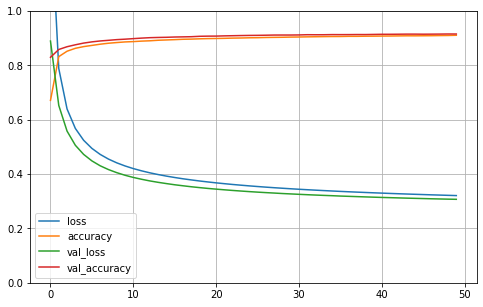

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [10]:
model.evaluate(X_test,Y_test)

313/313 [==============================] - 0s 414us/step - loss: 0.3068 - accuracy: 0.9156


[0.3068375587463379, 0.9156000018119812]

## 개선1 -  Hidden layer 추가하기.

- 위 신경망 모형의 test accuracysms 91.65% 
- 여기에 128개 뉴런을 갖는 hidden layer 추가하면?


In [9]:
import numpy as np
from tensorflow import keras

# network and training
EPOCHS = 50
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10   # number of outputs = number of digits
N_HIDDEN = 128
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION

# loading MNIST dataset
# verify
# the split between train and test is 60,000, and 10,000 respectly 
# one-hot is automatically applied
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784
#
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#normalize in [0,1]
X_train, X_test = X_train / 255.0, X_test / 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#one-hot
Y_train = tf.keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = tf.keras.utils.to_categorical(Y_test, NB_CLASSES)

#build the model
model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(N_HIDDEN,
   		input_shape=(RESHAPED,),
   		name='dense_layer', activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN,
   		name='dense_layer_2', activation='relu'))
model.add(keras.layers.Dense(NB_CLASSES,
   		name='dense_layer_3', activation='softmax'))


# build the model - alternative method

# model = keras.models.Sequential([
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])






# summary of the model
model.summary()

# compiling the model
model.compile(optimizer='SGD', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#training the model
model.fit(X_train, Y_train,
		batch_size=BATCH_SIZE, epochs=EPOCHS,
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

#evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

# making prediction
predictions = model.predict(X_test)


60000 train samples
10000 test samples
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer (Dense)          (None, 128)               100480    
_________________________________________________________________
dense_layer_2 (Dense)        (None, 128)               16512     
_________________________________________________________________
dense_layer_3 (Dense)        (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
375/375 [==============================] - 0s 1ms/step - loss: 1.4381 - accuracy: 0.6323 - val_loss: 0.7079 - val_accuracy: 0.8489
Epoch 2/50
375/375 [==============================] - 0s 1ms/step - loss: 0.5643 - accuracy: 0.8625 - val_loss: 0.4322 - val_accuracy: 0.8917
Epoch 3/50
375/375 [==============================] - 0

## 개선 2 - 드랍아웃

- 2개의 hidden layer를 추가하면 test accuracy가 96.39%로 증가
- 여기에 dropout을 사용하면?


In [5]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

# network and training
EPOCHS = 200
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10   # number of outputs = number of digits
N_HIDDEN = 128
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.3

# loading MNIST dataset
# verify
# the split between train and test is 60,000, and 10,000 respectly 
# one-hot is automatically applied
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784
#
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#normalize in [0,1]
X_train, X_test = X_train / 255.0, X_test / 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#one-hot
Y_train = tf.keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = tf.keras.utils.to_categorical(Y_test, NB_CLASSES)

#build the model
model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(N_HIDDEN,
   		input_shape=(RESHAPED,),
   		name='dense_layer', activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(N_HIDDEN,
   		name='dense_layer_2', activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(NB_CLASSES,
   		name='dense_layer_3', activation='softmax'))



# summary of the model
model.summary()

# compiling the model
model.compile(optimizer='SGD', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#training the moodel
model.fit(X_train, Y_train,
		batch_size=BATCH_SIZE, epochs=EPOCHS,
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

#evalute the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

# making prediction
predictions = model.predict(X_test)


60000 train samples
10000 test samples
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer (Dense)          (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
375/375 [==============================] - 0s 1ms/step - loss: 

## 개선 3 - 여러 최적화기 사용하기

- dropout을 사용하면 test accuracy가 97.74%로 증가
- 먼저 'RMSprop' 최적기를 사용하면?



In [12]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

#for tensorboard
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard('.logdir')

# network and training
EPOCHS = 50
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10   # number of outputs = number of digits
N_HIDDEN = 128
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.3

# loading MNIST dataset
# verify
# the split between train and test is 60,000, and 10,000 respectly 
# one-hot is automatically applied
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784
#
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#normalize in [0,1]
X_train, X_test = X_train / 255.0, X_test / 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#one-hot
Y_train = tf.keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = tf.keras.utils.to_categorical(Y_test, NB_CLASSES)

#build the model
model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(N_HIDDEN,
   		input_shape=(RESHAPED,),
   		name='dense_layer', activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(N_HIDDEN,
   		name='dense_layer_2', activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(NB_CLASSES,
   		name='dense_layer_3', activation='softmax'))

# summary of the model
model.summary()

# compiling the model
model.compile(optimizer='RMSProp', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#training the moodel
model.fit(X_train, Y_train,
		batch_size=BATCH_SIZE, epochs=EPOCHS,
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT,
		callbacks=[tensorboard_callback])

#evalute the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

# making prediction
predictions = model.predict(X_test)


60000 train samples
10000 test samples
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer (Dense)          (None, 128)               100480    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 128)               16512     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 

## 'Adam' 최적기를 사용하면?

- RMSprop (50 에포크)을 사용하면 97.88% 의 test_accuracy를 얻을 수 있었다.
- 'Adam'을 사용하면?

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

#for tensorboard
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard('.logdir')

# network and training
EPOCHS = 50
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10   # number of outputs = number of digits
N_HIDDEN = 128
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.3

# loading MNIST dataset
# verify
# the split between train and test is 60,000, and 10,000 respectly 
# one-hot is automatically applied
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784
#
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#normalize in [0,1]
X_train, X_test = X_train / 255.0, X_test / 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#one-hot
Y_train = tf.keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = tf.keras.utils.to_categorical(Y_test, NB_CLASSES)

#build the model
model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(N_HIDDEN,
   		input_shape=(RESHAPED,),
   		name='dense_layer', activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(N_HIDDEN,
   		name='dense_layer_2', activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(NB_CLASSES,
   		name='dense_layer_3', activation='softmax'))

# summary of the model
model.summary()

# compiling the model
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# # callbacks

# callbacks=[
#     tf.keras.callbacks.TensorBoard(log_dir='./logs/example')
# ]


#training the moodel
model.fit(X_train, Y_train,
		batch_size=BATCH_SIZE, epochs=EPOCHS,
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT,
		callbacks=[tensorboard_callback])


#evalute the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

# making prediction
predictions = model.predict(X_test)


60000 train samples
10000 test samples
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer (Dense)          (None, 128)               100480    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 128)               16512     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 

## 추가 개선 방법 

- 가중치 초기화 설정, 배치정규화 등
- hyperparameter 조정하기
    - 학습률
    - 은닉층의 수, 뉴런 수
    - batch size
    - ephoc 수

In [22]:
!tensorboard --logdir= /logs/example/

SyntaxError: invalid syntax (<ipython-input-22-659355af52fe>, line 1)